Example 2.75
============

This notebook is available on github
[here](https://github.com/aezarebski/aas-extended-examples). If you find
errors or would like to suggest an improvement, feel free to create an
issue.

As usual we will start by importing some useful libraries.

In [1]:
%matplotlib inline
import statsmodels.api as sm
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import numpy as np

Today we will look at a dataset from a double-blind clinical trial of a new treatment for rheumatoid arthritis. We will test whether treatment is correlated with a change in symptoms using a $\chi^{2}$-test.

First, we need to load the data which comes bundled with `statsmodels`.

In [2]:
ra = sm.datasets.get_rdataset("Arthritis", "vcd").data
ra.head()

,ID,Treatment,Sex,Age,Improved
0,57,Treated,Male,27,Some
1,46,Treated,Male,29,None
2,77,Treated,Male,30,None
3,17,Treated,Male,32,Marked
4,36,Treated,Male,46,Marked


### Question

Use `pandas` to generate a cross tabulation of the treatment status and improvement.

[hint](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html)

### Answer

In [3]:
outcome_tbl = pd.crosstab(ra.Treatment, ra.Improved)
print(outcome_tbl)

Improved   Marked  None  Some
Treatment                    
Placebo         7    29     7
Treated        21    13     7


### Question

Generate a mosaic plot to display this data.

[hint](https://www.statsmodels.org/dev/generated/statsmodels.graphics.mosaicplot.mosaic.html)

### Answer

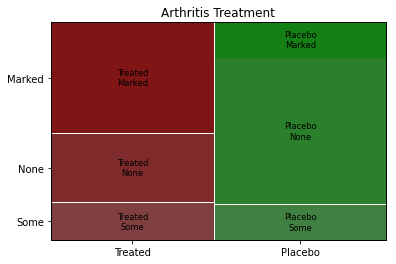

In [4]:
mosaic(ra, ['Treatment','Improved'], title = "Arthritis Treatment")
plt.show()

### (Bonus) question

What fundamental error does the default plot from `pandas` make?

### Answer

1. It uses red and green as the only colours which likely to be difficult for people with colour blindness.
2. It has not respected the implicit ordering of response values.

The figure below makes the pattern in the data far clearer (at the expense of few lines of code).

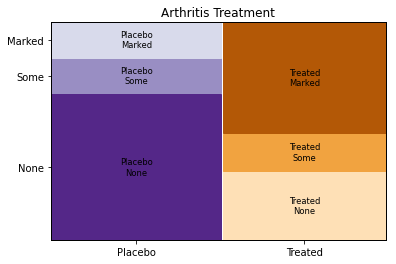

In [5]:
ra['Improved'] = pd.Series(
    pd.Categorical(ra.Improved, 
                 categories=['None','Some','Marked'], 
                 ordered=True))

props = lambda key: {'color': 'r' if 'a' in key else 'gray'}
props = {}
props[('Treated','Marked')] = {'color': '#b35806'}
props[('Treated','Some')] = {'color': '#f1a340'}
props[('Treated','None')] = {'color': '#fee0b6'}
props[('Placebo','Marked')] = {'color': '#d8daeb'}
props[('Placebo','Some')] = {'color': '#998ec3'}
props[('Placebo','None')] = {'color': '#542788'}

mosaic(ra, ['Treatment','Improved'], title = "Arthritis Treatment", properties=props)
plt.show()

### Question

For this trial, what was the null hypothesis?

### Answer

The null hypothesis is that any change in symptoms is independent of whether the patient recieved the treatment or a placebo.

### Question

Is it valid to use a $\chi^{2}$-test for this data?

### Answer

We have more than 5 counts in each cell of the table, so we can use the $\chi^{2}$-test. Be warned, some statisticians would prefer that you had at least 10 in each cell.

### Question

How many degrees of freedom are there in this data?

### Answer

Two, because there are two rows of three columns and $(2 - 1)(3 - 1) = 2$.

### Question

Perform a $\chi^{2}$-test on the contingency table; are treatment and changes in symptoms independent?

### Answer

The following code carries out the test and allows us to reject the null hypothesis.

In [6]:
chi2, p, dof, expected = scipy.stats.chi2_contingency(outcome_tbl.to_numpy())
print(chi2)
print(p)
print(dof)
print(expected)

13.055019852524108
0.0014626434089526504
2
[[14.33333333 21.5         7.16666667]
 [13.66666667 20.5         6.83333333]]


### (Bonus) Question

What can we conclude from this hypothesis test? Why do we need to randomise the treatment?

### Answer

- We can conclude that treatment and changes in symptoms are not independent.
- Randomisation helps avoid confounding factors which lends more credibility to the conclusion that the treatment improves the condition.

Note that a proper treatment of *causality* goes well beyond the scope of this course, but recall that randomised controlled trials provide very very high quality evidence.

Recall from earlier notebooks the function `estimate_and_ci` which computes the probability of success in repeated Bernoulli trials and the $95\%$ confidence interval on this estimate.

In [7]:
def estimate_and_ci(num_trials, num_success):
    p_hat = num_success / num_trials
    z = 1.96
    delta = z * np.sqrt(p_hat * (1 - p_hat) / num_trials)
    return (p_hat,(p_hat - delta, p_hat + delta))

The functions `rand_small_table` and `rand_big_table` defined below return random datasets of the same shape as out arthritis dataset under the null hypothesis in which the outcome is independent of treatment. The `rand_small_table` returns data from a smaller cohort and the `rand_big_table` returns data from a larger cohort. 

In [8]:
_, _, _, expected = scipy.stats.chi2_contingency(outcome_tbl.to_numpy())

def rand_small_table():
    x = np.array(0)
    while x.min() < 1:
        x = scipy.stats.poisson.rvs(mu = np.array(0.5) * expected)
    return x

def rand_big_table():
    x = np.array(0)
    while x.min() < 1:
        x = scipy.stats.poisson.rvs(mu = np.array(1.5) * expected)
    return x

### Question

Using the functions `estimate_and_ci`, and `rand_small_table` and `rand_big_table`, demonstrate how the $\chi^{2}$-test will fail if the cell values are too small.

### Answer

The false positive test suggests that the test will not be powerful enough on smaller tables.

In [9]:
num_trials = 10000
false_pos_count = 0
for _ in range(num_trials):
    x = rand_small_table()
    _, p, _, _ = scipy.stats.chi2_contingency(x)
    if p < 0.1:
        false_pos_count+=1 
print(estimate_and_ci(num_trials, false_pos_count))

(0.0846, (0.07914560347844053, 0.09005439652155946))
